# Covid Case Prediction Using Deep Learning

**Objective:** Given survey results in the past 3 days in a specific state in U.S., predict the percentage of new tested positive cases in the 3rd day.

This notebook is divided into the following sections:

1. Data Exploration
2. Data Preparation
3. Data Modeling
4. Empirical Results and Evaluation

## Data Exploration

Performing some preliminary data analysis.

In [2]:
import pandas as pd
import numpy as np

In [110]:
# Loading the datasets
train_df = pd.read_csv('covid.train.csv')
test_df = pd.read_csv('covid.test.csv')

train_df.head()

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [111]:
# Printing columns of the dataset
# Test df should contain all same columns as train df except the target column
assert set(train_df.columns) == set(test_df.columns) | {'tested_positive.2'}
print(train_df.columns)

Index(['id', 'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL',
       'IN', 'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE',
       'NV', 'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX',
       'UT', 'VA', 'WA', 'WV', 'WI', 'cli', 'ili', 'hh_cmnty_cli',
       'nohh_cmnty_cli', 'wearing_mask', 'travel_outside_state',
       'work_outside_home', 'shop', 'restaurant', 'spent_time', 'large_event',
       'public_transit', 'anxious', 'depressed', 'felt_isolated',
       'worried_become_ill', 'worried_finances', 'tested_positive', 'cli.1',
       'ili.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'wearing_mask.1',
       'travel_outside_state.1', 'work_outside_home.1', 'shop.1',
       'restaurant.1', 'spent_time.1', 'large_event.1', 'public_transit.1',
       'anxious.1', 'depressed.1', 'felt_isolated.1', 'worried_become_ill.1',
       'worried_finances.1', 'tested_positive.1', 'cli.2', 'ili.2',
       'hh_cmnty_cli.2', 'nohh_cmnty_cli.2', 'wea

**Dataset Attributes**

Here, we see how this dataset is structured. Since it is a survey data, it includes the the answers of some questions, such as whether or not the surveyer was wearing a mask, using public transport, traveled out of state, etc., as well as the state of residence.

Columns have been one hot encoded (specifically for state), meaning we don't have to do a lot of preprocessing. As a safety measure, we will drop any rows with missing values.

We will also drop the 'id' column, since it is not relevant to our predictions.

In [112]:
# Dropping the rows with missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Drop duplicates
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# Drop 'id' column
train_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [71]:
# Checking the distribution of survey answers by state
import matplotlib.pyplot as plt

# Getting columns that we need (indexes 0 to 40)
state_columns = train_df.columns[0:40]
print(state_columns)
print(len(state_columns))

Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'FL', 'GA', 'ID', 'IL', 'IN',
       'IA', 'KS', 'KY', 'LA', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'NE', 'NV',
       'NJ', 'NM', 'NY', 'NC', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TX', 'UT',
       'VA', 'WA', 'WV', 'WI'],
      dtype='object')
40


We see that some states are missing (only 40 states included in the survey), but we will continue

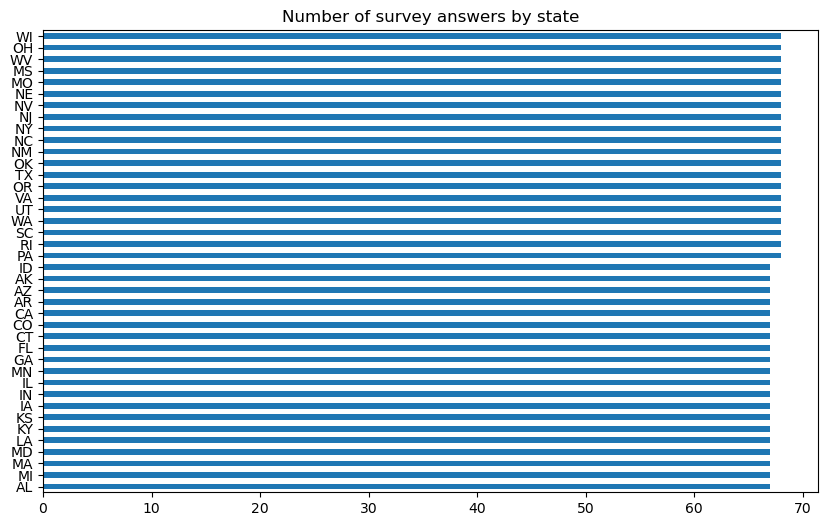

In [72]:
# Visualizing the number of survey answers for each state
plt.figure(figsize=(10, 6))
train_df[state_columns].sum().sort_values().plot(kind='barh')
plt.title('Number of survey answers by state')
plt.show()

We see that each state included in the survey is adequately represented. 

Now, a correlation matrix of features.

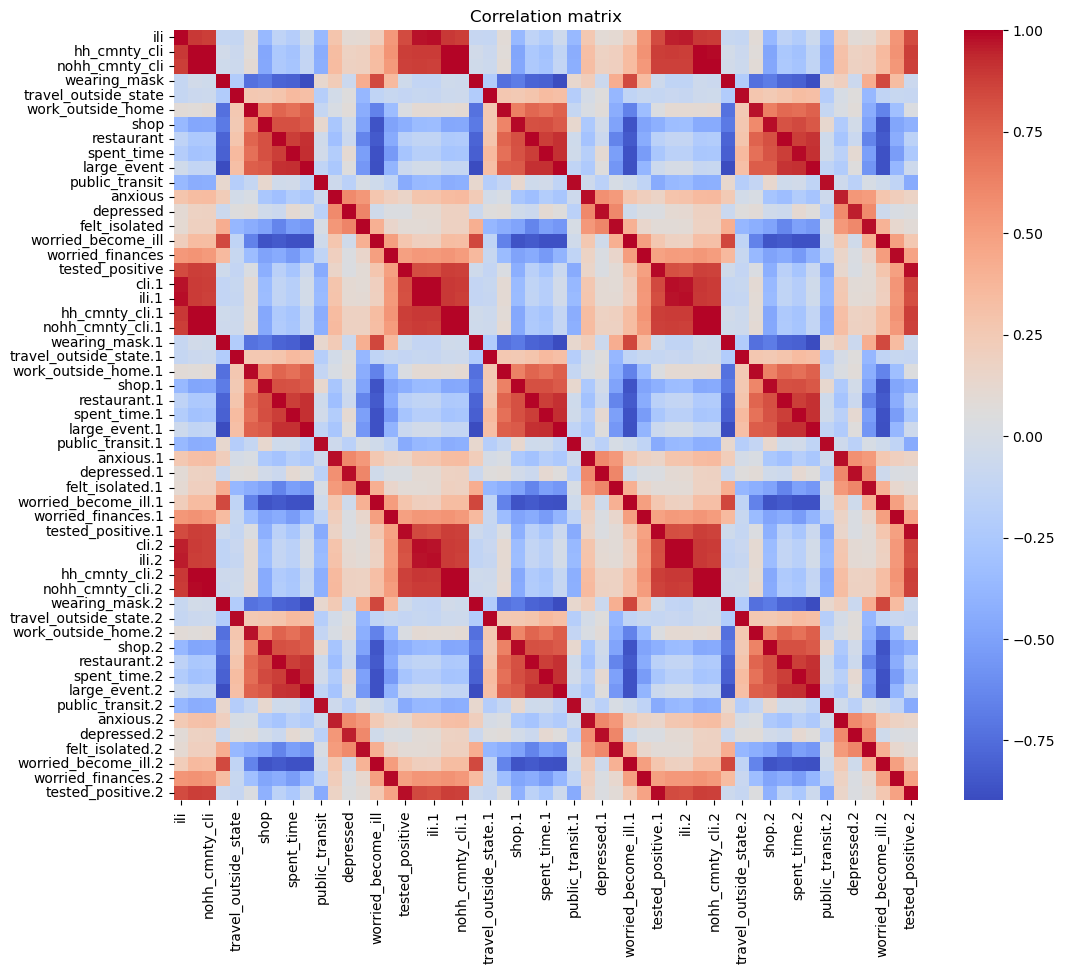

In [73]:
# Correlation matrix of features (minus the state columns)
import seaborn as sns

features = train_df.columns[41:]
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[features].corr(), cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Heatmap interpretation:

1. Features seperated by day (day 0, day 1, day 2)
2. Strong correlation between day 0, day 1, day 2 features (i.e., wearing_mask, wearing_mask.1, wearing_mask.2). Makes sense in the context of the dataset since we are trying to predict positive rate on 3rd day
3. Noticable correlation variance between features are target variable (test_positive)

These findings help us better understand the dataset. Moving onto data preparation using PyTorch.

## Data Modeling: Fully Connected Neural Network

Implementing a deep NN using Pytorch.

To start, we will implement a simple fully connected neural network to establish a baseline performance. Given the nature of the data, there is a chance that the data exhibits strong temporal or spatial dependency (i.e., survey answers from day 0 heavily influence the tested_positive.2). 

I have considered implementing an LSTM NN, which is designed for sequential data, but before moving forward with this it is important to start with a baseline model. After we evaluate the fully connected performance, we will decide whether or not to implement a more complex model.

To implement this model, we will to take the following steps:

1. Data Preparation
2. Define Model
3. Define loss function and optimizer
4. Train the model
5. Evaluate the model

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Data Preparation**

In order to train our model, the data must be converted to tensors. Pytorch has built in classes to conveniently handle datasets

**TensorDataset** stores the samples and their corresponding labels in singular dataset

**DataLoader** wraps an iterable around the Dataset to enable easy access to samples. Allows for batching and shuffling the training dataset.

*from PyTorch docs*

In [76]:
# Seperating features and target (tested_postive.2)
X = train_df.drop(columns=['tested_positive.2']).values # Features
y = train_df['tested_positive.2'].values # Target

# Converting to torch tensors
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

# Creating dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

**Define Fully Connected Network**

Defining neural network with the following architecture:

- Input layer, taking features as input
- 3 hidden layers with decreasing neuron input/output (128, 64, 32)
- Output layer (tested_positve percentage on day 3)

Each layer will use the ReLu activation function when progressing through the network (defined in the forward method)

This network inherits nn.Module, which is PyTorch's built in module containing some network methods.

In [77]:
class FullyConnectedNN(nn.Module):
    # Defining fully connected neural network, inheriting from nn.Module
    # Input layer (n features x 128 neurons) --> 
    # Hidden layer 1 (128 nuerons x 64 neurons) --> 
    # Hidden layer 2 (64 nuerons x 32 neurons) -->
    # Output layer (probability of testing positive), 32 neurons x 1 neuron
    def __init__(self, n_features):
        super(FullyConnectedNN, self).__init__()
        self.fc1 = nn.Linear(n_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

**Define Model, Loss Function and Optimizer**

Defining the model with input size as the # of features in our dataset.

Setting loss function as MSE since we are working on a regression task. Since we are dealing with a percentage, this value gives us a normalized metric to evaluate our results.

Using adam optimizer, common practice in deep learning tasks. This optimzer adjusts the learning rate of each parameter individually, often leading to faster convergence. We set the learning rate at .01.

In [84]:
# Instantiating the model
input_size = X.shape[1]
model = FullyConnectedNN(input_size).to(device)

# Defining the loss function and optimizer
criterion = nn.MSELoss() # Using MSE loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.01) # Using Adam optimizer

In [85]:
print(model)

FullyConnectedNN(
  (fc1): Linear(in_features=93, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


**Train the Model**

We will train the model by implementing the following:

1. Training Loop: first iterates over the data for specified # of epochs. Inner loop iterates over the batches of data from dataloader, where each iteration processes one mini batch 

2. Zero Gradients: setting gradients back to zero for each iteration

3. Forward pass: inputs the data into the model, then computes the output. outputs.squeeze() is used to remove any extra dimensions from the output tensor

4. Calculate loss: loss function compared predicted - actual

5. Backward pass (backpropogation): the backward pass calculates the gradients of the loss with respect to the model's parameters

6. Optimization step: updates model parameters based on computed gradients

7. Monitor Progress: finally, an if statement is added to track the performance of the model -- printing the results after 10 epochs

In [86]:
# Training the model
n_epochs = 100

for epoch in range(n_epochs):
    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass (backpropagation)
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0: # Print loss every 10 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 4.816267013549805
Epoch 10, Loss: 1.9140939712524414
Epoch 20, Loss: 2.2558231353759766
Epoch 30, Loss: 1.2228686809539795
Epoch 40, Loss: 1.3533179759979248
Epoch 50, Loss: 0.9235090613365173
Epoch 60, Loss: 1.400083065032959
Epoch 70, Loss: 0.8033711314201355
Epoch 80, Loss: 1.335214376449585
Epoch 90, Loss: 0.7020187377929688


**Model Evaluation**

In [87]:
model.eval()

FullyConnectedNN(
  (fc1): Linear(in_features=93, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [113]:
with torch.no_grad():
    predictions = model(X)
    mse = criterion(predictions.squeeze(), y)
    print(f'Mean Squared Error on the training set: {mse.item():.4f}')

Mean Squared Error on the training set: 1.0028


In [114]:
# Making predictions on the test set
X_test = test_df.values
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

with torch.no_grad():
    predictions = model(X_test)
    
# Converting predictions to a pandas DataFrame
predictions_df = pd.DataFrame(predictions.cpu().numpy(), columns=['tested_positive.2'])


In [117]:
# Comparing predicted tested_positve.2 with tested_positive and test_positive.1
test_df['tested_positive.2'] = predictions_df
test_df[['tested_positive', 'tested_positive.1', 'tested_positive.2']].head(10)


,tested_positive,tested_positive.1,tested_positive.2
0,22.055633,21.029253,20.126184
1,2.331589,2.011478,3.172193
2,1.658765,2.163458,3.342746
3,11.600093,11.151200,10.153695
4,2.458395,2.525252,2.821020
5,25.342487,27.963939,27.858049
6,27.283061,26.082381,25.901239
7,8.750022,6.692929,5.993332
8,11.784153,10.946757,11.221435
9,10.335195,10.335195,9.549380


***Notes on LSTM***

Since we are dealing with time series data, one approach is to implement an LSTM neural network. This approach was considered because LSTMs are best for capturing nuanced temporal patterns that could be exhibited in this data. In our case, a simple RNN might suffice -- but LSTMs provide a more robust and flexible option. 

LSTMs allow for more flexible hyperparameter tuning. They are more complex than simple RNNs and should be able to capture the nature of the data more effectively. Even though we are dealing with a short period of time (3 days), this model should hopefully make the most accurate predictions on the percentage of positive cases on the 3rd day.


## Empirical Results and Conclusion

In [5]:
#TODO: